In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
from time import sleep
import os
import cv2

from tensorflow.keras.layers import Dense, Conv2D, Activation, Flatten, Dropout, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.optimizers import SGD, Adam

In [118]:
#This section of code will take your vidoe picture and crop your face to a predfeined size
#This is used for face annotation 
#If you already face images - skip this section

#The cascade classifier below is sved into your opencv directory - 
#Change the path to where haarcascade_frontalface_default.xml is located in your directory.
face_cascade = cv2.CascadeClassifier('/home/krishkar/anaconda3/share/OpenCV/haarcascades/haarcascade_frontalface_default.xml')


img_size = 299
cam = cv2.VideoCapture(0)

cv2.namedWindow("test")

img_counter = 0

while(True):
    ret, frame = cam.read()
    faces = face_cascade.detectMultiScale(frame, 1.3, 5)
    for (x,y,w,h) in faces:
        if w >130:
            detected_face = frame[int(y):int(y+h), int(x):int(x+w)] 
            cv2.imshow("test", detected_face)
    if not ret:
        break
    k = cv2.waitKey(1)

    if k%256 == 27:
        # ESC pressed
        print("hit Esc to skipe and hit Space bar to save image")
        break
    elif k%256 == 32:
        # SPACE pressed 
        faceresize = cv2.resize(detected_face, (img_size,img_size)) 
        img_name = "dataset/opencv_frame_{}.jpg".format(img_counter)
        cv2.imwrite(img_name, faceresize)
        print("{} written!".format(img_name))
        img_counter += 1
    
cam.release()

cv2.destroyAllWindows()

dataset/opencv_frame_0.jpg written!
hit Esc to skipe and hit Space bar to save image


In [2]:
#Keypoint determination
#Proceed to this section once you have face images, face keypoint and face keypoint csv as indicared in the book
#Read data files
train_path = 'faceimagestrain/trainimgface.csv'
test_path = 'faceimagestrain/testimgface.csv'
train_data = pd.read_csv(train_path)  
test_data = pd.read_csv(test_path)

In [3]:
train_data.head()

,0x,0y,1x,1y,2x,2y,3x,3y,4x,4y,...,11y,12x,12y,13x,13y,14x,14y,15x,15y,image
0,130,127,146,126,156,127,193,145,203,148,...,181,195,217,164,247,111,209,78,182,trainimg_1.jpg
1,108,163,114,155,119,151,145,131,152,123,...,162,220,209,169,248,131,224,120,195,trainimg_2.jpg
2,103,135,115,131,126,133,166,131,178,126,...,164,214,200,162,237,108,214,96,176,trainimg_3.jpg
3,98,137,107,133,122,129,162,131,174,125,...,166,204,218,155,254,101,220,90,185,trainimg_4.jpg
4,103,145,113,135,123,135,155,129,164,120,...,175,224,210,170,251,122,215,111,181,trainimg_5.jpg


In [4]:
train_data.shape[1]

33

In [5]:
test_data.head()

,0x,0y,1x,1y,2x,2y,3x,3y,4x,4y,...,11y,12x,12y,13x,13y,14x,14y,15x,15y,image
0,117,128,127,126,133,123,149,122,157,117,...,160,175,187,158,205,130,192,119,170,testimg_1.jpg
1,87,71,109,71,123,75,180,75,193,70,...,126,213,152,148,170,106,158,71,119,testimg_2.jpg
2,123,154,138,150,156,150,197,155,206,154,...,193,203,217,170,228,133,218,104,190,testimg_3.jpg
3,116,121,123,117,132,114,152,111,164,101,...,160,184,186,152,219,127,204,118,172,testimg_4.jpg
4,87,145,94,141,103,137,140,135,152,131,...,172,182,192,149,214,111,207,91,184,testimg_5.jpg


In [6]:
#Rearrange train data and break down to X and Y
#X is image and Y is keypoints (32 in this example)
coltrn = train_data['image']
img_paths = []
imgs = []
print (coltrn.shape[0])
training = train_data.drop('image',axis = 1)
Y_train = []
for i in range (coltrn.shape[0]):
    p = os.path.join(os.getcwd(), 'faceimagestrain/'+str(coltrn.iloc[i]))

    img = cv2.imread(p, 1)
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imgs.append(RGB_img)
    
    y = training.iloc[i,:]
    Y_train.append(y)

X_train = np.asarray(imgs)

Y_train = np.array(Y_train,dtype = 'float')  

print(X_train.shape, Y_train.shape)
    

50
(50, 299, 299) (50, 32)


In [7]:
#Rearrange test data and break down to X and Y
#X is image and Y is keypoints (32 in this example)
coltst = test_data['image']
img_paths = []
imgstst = []
print (coltst.shape[0])
testing = test_data.drop('image',axis = 1)
Y_test = []
for i in range (coltst.shape[0]):
    p = os.path.join(os.getcwd(), 'faceimagestrain/'+str(coltst.iloc[i]))
    imgtst = cv2.imread(p, 1)
    RGB_imgtst = cv2.cvtColor(imgtst, cv2.COLOR_BGR2GRAY)
    imgstst.append(RGB_imgtst)
    
    y = testing.iloc[i,:]
    Y_test.append(y)

X_test = np.asarray(imgstst)

Y_test = np.array(Y_test,dtype = 'float')  

print(X_test.shape, Y_test.shape)



7
(7, 299, 299) (7, 32)


In [8]:
# Break down the Y value in X and Y components as Y_trainx, Y_trainy for plotting
Y_trainx = training.loc[:,['0x','1x','2x','3x','4x','5x','6x','7x','8x','9x','10x','11x','12x','13x','14x','15x']] 
Y_trainy = training.loc[:,['0y','1y','2y','3y','4y','5y','6y','7y','8y','9y','10y','11y','12y','13y','14y','15y']] 

print(Y_trainx.shape, Y_trainy.shape)
Y_trainx.head()

(50, 16) (50, 16)


,0x,1x,2x,3x,4x,5x,6x,7x,8x,9x,10x,11x,12x,13x,14x,15x
0,130,146,156,193,203,207,187,143,164,183,171,206,195,164,111,78
1,108,114,119,145,152,162,130,142,153,164,146,240,220,169,131,120
2,103,115,126,166,178,190,148,130,149,173,153,222,214,162,108,96
3,98,107,122,162,174,193,144,131,148,177,146,227,204,155,101,90
4,103,113,123,155,164,178,136,140,153,168,151,247,224,170,122,111


In [9]:
Y_trainy.head()

,0y,1y,2y,3y,4y,5y,6y,7y,8y,9y,10y,11y,12y,13y,14y,15y
0,127,126,127,145,148,156,169,196,202,205,197,181,217,247,209,182
1,163,155,151,131,123,121,161,207,205,195,194,162,209,248,224,195
2,135,131,133,131,126,126,159,195,198,189,189,164,200,237,214,176
3,137,133,129,131,125,130,165,207,208,204,192,166,218,254,220,185
4,145,135,135,129,120,117,169,206,200,193,195,175,210,251,215,181


In [10]:
# Break down the Y value in X and Y components as Y_testx, Y_testy for plotting
Y_testx = testing.loc[:,['0x','1x','2x','3x','4x','5x','6x','7x','8x','9x','10x','11x','12x','13x','14x','15x']] 
Y_testy = testing.loc[:,['0y','1y','2y','3y','4y','5y','6y','7y','8y','9y','10y','11y','12y','13y','14y','15y']] 

print(Y_testx.shape, Y_testy.shape)
Y_testx.head()

(7, 16) (7, 16)


,0x,1x,2x,3x,4x,5x,6x,7x,8x,9x,10x,11x,12x,13x,14x,15x
0,117,127,133,149,157,166,148,133,152,172,153,181,175,158,130,119
1,87,109,123,180,193,211,155,127,154,184,164,243,213,148,106,71
2,123,138,156,197,206,220,173,153,176,200,175,222,203,170,133,104
3,116,123,132,152,164,175,145,136,145,158,150,190,184,152,127,118
4,87,94,103,140,152,162,131,123,137,157,142,196,182,149,111,91


In [11]:
X_train[0].shape

(299, 299)

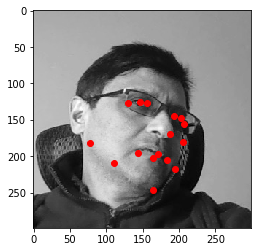

In [12]:
#Example of training image with keypoint from data
x0=Y_trainx.iloc[0,:]
y0=Y_trainy.iloc[0,:]
plt.imshow(np.squeeze(X_train[0]),cmap='gray')
plt.scatter(x0, y0,color ='red')
plt.show()

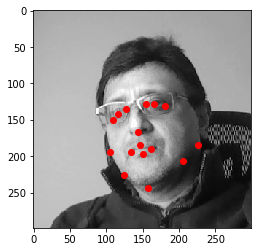

In [77]:
#Example of test image with keypoint from data (image #7)
x0t=Y_testx.iloc[6,:]
y0t=Y_testy.iloc[6,:]
plt.imshow(np.squeeze(X_test[6]),cmap='gray')
plt.scatter(x0t, y0t,color ='red')
plt.show()

In [13]:
#Contruct the neural network model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(299,299,1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(500, activation='relu'))
model.add(Dense(500, activation='relu'))

model.add(Dense(32))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 299, 299, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 145, 145, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 72, 72, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 72, 72, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 70, 70, 128)       7

In [96]:
#Define model loss parameter
adam = Adam(lr=0.001)
model.compile(adam, loss='mean_squared_error', metrics=['accuracy'])

In [97]:
#Reshape data for input to Keras model
batchsize = 10
X_train= X_train.reshape(50,299,299,1)
X_test= X_test.reshape(7,299,299,1)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(50, 299, 299, 1) (50, 32) (7, 299, 299, 1) (7, 32)


In [98]:
#Begin training
history = model.fit(X_train, Y_train, validation_data=(X_test,Y_test), epochs=20, batch_size=batchsize)

Epoch 1/20
5/5 [==============================] - 4s 872ms/step - loss: 50485.5781 - accuracy: 0.6400 - val_loss: 17747.0703 - val_accuracy: 0.1429
Epoch 2/20
5/5 [==============================] - 4s 852ms/step - loss: 20850.9258 - accuracy: 0.0600 - val_loss: 21925.0039 - val_accuracy: 0.1429
Epoch 3/20
5/5 [==============================] - 4s 850ms/step - loss: 17220.5508 - accuracy: 0.0600 - val_loss: 2555.2026 - val_accuracy: 0.1429
Epoch 4/20
5/5 [==============================] - 4s 864ms/step - loss: 5808.9170 - accuracy: 0.0600 - val_loss: 6269.1655 - val_accuracy: 0.2857
Epoch 5/20
5/5 [==============================] - 4s 864ms/step - loss: 4922.8218 - accuracy: 0.7400 - val_loss: 2975.4858 - val_accuracy: 0.5714
Epoch 6/20
5/5 [==============================] - 4s 859ms/step - loss: 1716.4440 - accuracy: 0.9000 - val_loss: 1056.8119 - val_accuracy: 0.5714
Epoch 7/20
5/5 [==============================] - 4s 889ms/step - loss: 935.9250 - accuracy: 0.7800 - val_loss: 1199.43

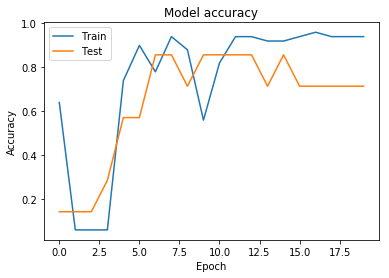

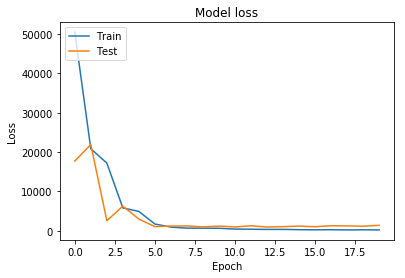

In [99]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [100]:
#Predict model output against test data
y_val = model.predict(X_test)

In [101]:
#Breakdown model output into x and y column so we can plot the keypoint as a scatter plot
yvalx = y_val[::1,::2]
yvaly = y_val[:, 1::2]

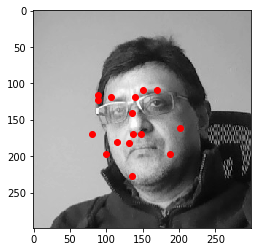

In [116]:
#Display key point prediction for image #7 on the face image (comapre with test image data above)
plt.imshow(np.squeeze(X_test[6]),cmap='gray')
plt.scatter(yvalx[6], yvaly[6], color = 'red')

plt.show()